In [37]:
%matplotlib inline

from __future__ import print_function
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units

import random
import tables as tb
import numpy as np
import tensorflow as tf

NSIPM = 1792

-----------------------------------------
# Generation of test events

*Note: the code below should be run within the IC environment because it uses the load_db module.*

The following generates the specified number of "test" events.  Some number less than the target number may be generated due to the random positioning of points (some points may not fall over the SiPM plane and will therefore give no response and the event will be removed).  To use this:

1.  Set the number of events and number of points per event in the cell just below
2.  Run all following cells.  In the end one will be left with the following arrays indexed by event number:
    X0: the true x-coordinates (array of length equal to number of points generated)
    Y0: the true y-coordinates (array of length equal to number of points generated)
    X: the SiPM x-coordinates (array of length equal to number of SiPMs with nonzero response)
    Y: the SiPM y-coordinates (array of length equal to number of SiPMs with nonzero response)
    Q: the SiPM responses (array of length equal to number of SiPMs with nonzero response)

### Set the parameters here

In [2]:
# parameters
nevts = 10      # number of events to generate
num_elpts = 1   # number of EL points per event

### Run the following cells to generate the events

In [3]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_ids,l_X,l_Y,l_Q,l_X0,l_Y0,sipm_xvals,sipm_yvals):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    if(hasattr(l_X0, "__len__")):
        for xx,yy in zip(l_X0,l_Y0):
            mrk = Ellipse(xy=(xx,yy), width=4., height=4.)
            mrk.set_facecolor('b')
            ax1.add_artist(mrk)
    else:
        mrk = Ellipse(xy=(l_X0,l_Y0), width=4., height=4.)
        mrk.set_facecolor('b')
        ax1.add_artist(mrk)
        
    # place a large red circle for reconstructed points
    #if(ept is not None):
    #    xpt = ept[0]*fscale - fshift*fscale
    #    ypt = ept[1]*fscale - fshift*fscale
    #    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    #    mrk.set_facecolor('r');
    #    ax1.add_artist(mrk);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [4]:
M = [1.599, 1.599]
c0 = [7.72708346764e-05, 0.000116782596518]
c1 = [-1.69330613273e-07, 3.05115354927e-06]
c2 = [-1.52173658255e-06, -7.00800605142e-06]
c3 = [-2.4985972302e-07, 6.53907883449e-07]
c4 = [1.12327204397e-07, 8.95230202525e-08]
c5 = [-1.49353264606e-08, -2.27173290582e-08]
c6 = [1.04614146487e-09, 2.00740799864e-09]
c7 = [-4.19111362353e-11, -9.21915945523e-11]
c8 = [9.12129133361e-13, 2.20534216312e-12]
c9 = [-8.40089561697e-15, -2.1795164563e-14]

# Maximum radial extent of parameterization
rmax = 20.

# Return the SiPM response for the specified time bin and radial distance.
def sipm_par(tbin,r):

    # Ensure the time bin value is valid.
    if(tbin < 0 or tbin >= 2):
        print("Invalid time bin in sipm_param: returning 0.0 ...")
        return 0.0

    # Calculate the response based on the parametrization.
    vpar = M[tbin]*(c0[tbin] + c1[tbin]*r + c2[tbin]*r**2 + c3[tbin]*r**3 +
    c4[tbin]*r**4 + c5[tbin]*r**5 + c6[tbin]*r**6 + c7[tbin]*r**7 +
    c8[tbin]*r**8 + c9[tbin]*r**9)

    # Zero the response for radii too large.
    if(hasattr(vpar, "__len__")):
        ret = np.zeros(len(vpar)); iret = 0
        for rv,pv in zip(r,vpar):
            if(rv < rmax):
                ret[iret] = pv
            iret += 1
        return ret
    else:
        if(r < rmax):
            return vpar

In [5]:
# make arrays of (X,Y) coordinates for use in producing test events
def make_xy(nevts, max_x, max_y, num_elpt):
    
    if num_elpt == 1: X = np.random.uniform(0,max_x,(nevts,num_elpt))
    else:
        X = np.empty((nevts,num_elpt),dtype=np.float32)
        
        # space x coordinates out so that the net can differentiate between pt1, pt2, etc
        for pt in range(num_elpt): 
            X[:,pt] = np.random.uniform(pt*max_x/num_elpt,(pt+1)*max_x/num_elpt, nevts)
  
    Y = np.random.uniform(0,max_y,(nevts,num_elpt))
    return np.array(X),np.array(Y)

In [12]:
def generate_sipm_responses(nevts, X, Y, X_sipm, Y_sipm):
    sipm_res = np.zeros((nevts,NSIPM),dtype=np.float32) # SiPM responses
    
    for evt in range(nevts):
        for x,y in zip(X[evt],Y[evt]):           # each event
            xi = X_sipm; yi = Y_sipm
            r = np.sqrt((xi - x)**2 + (yi - y)**2)
            sipm_res[evt] += sipm_par(0,r) + sipm_par(1,r)

        # Normalize to 1
        norm = np.max(sipm_res[evt])
        if(norm > 0):
            sipm_res[evt] /= norm

    # get the nonzero IDs and values for each event
    _ids = []; _x = []; _y = []; _qs = []
    for sevt in sipm_res:
        idevt = np.nonzero(sevt)
        xt = X_sipm[idevt]
        yt = Y_sipm[idevt]
        _ids.append(idevt)
        _x.append(xt)
        _y.append(yt)
        _qs.append(sevt[idevt])
    
    _ids = np.array(_ids)
    _x = np.array(_x)
    _y = np.array(_y)
    _qs = np.array(_qs)
    return (_ids, _x, _y, _qs)

In [13]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
xs = DataSensor.X.values
ys = DataSensor.Y.values

# create (x,y) lists
_sipm_x = np.zeros(NSIPM)
_sipm_y = np.zeros(NSIPM)
for ID, x, y in zip(range(NSIPM), xs, ys):
    _sipm_x[ID] = x
    _sipm_y[ID] = y

In [16]:
# create x-y points for the events
X0,Y0 = make_xy(nevts,max(_sipm_x),max(_sipm_y),num_elpts)

# generate the SiPM responses for the events
(ids,X,Y,Q) = generate_sipm_responses(nevts,X0,Y0,_sipm_x,_sipm_y)

# remove values for which no SiPM response was found
remove_indx = []
for ee in range(nevts):
    if(len(Q[ee]) == 0):
        remove_indx.append(ee)
if(len(remove_indx) > 0):
    ids = np.delete(ids,remove_indx)
    X0 = np.delete(X0,remove_indx)
    Y0 = np.delete(Y0,remove_indx)
    X = np.delete(X,remove_indx)
    Y = np.delete(Y,remove_indx)
    Q = np.delete(Q,remove_indx)
    
print("Generated {0} events.".format(len(Q)))

Generated 6 events.


### Plot one of the events

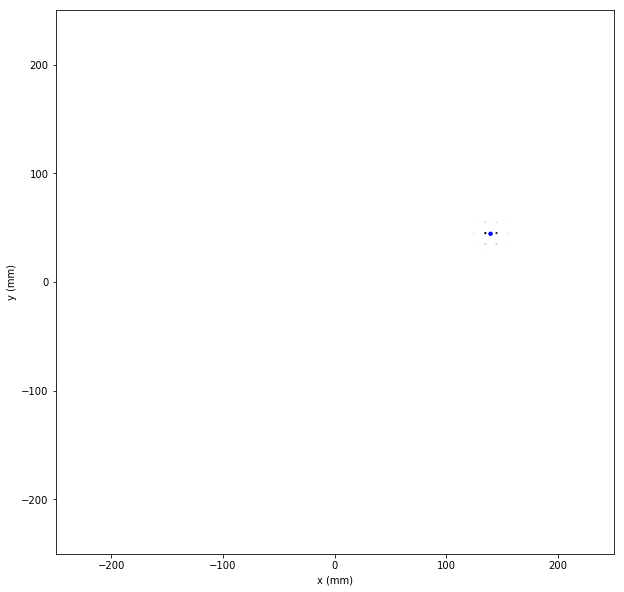

In [28]:
# plot a test event
t_evt = 0
plot_test_event(ids[t_evt],X[t_evt],Y[t_evt],Q[t_evt],X0[t_evt],Y0[t_evt],_sipm_x,_sipm_y)

----------------------

# Reconstruction functions

The reconstruction function `reco_algorithm` we are aiming for is to be called by the `compute_xy_position` function of `HitCollectionCity`, shown below:

```python
    def compute_xy_position(self, si, slice_no):
        si      = pmp.select_si_slice(si, slice_no)
        IDs, Qs = map(list, zip(*si.items()))
        xs, ys  = self.xs[IDs], self.ys[IDs]
        return self.reco_algorithm(xs, ys, Qs)
```

The idea is to return a list of clusters with their (x,y) reconstructions.  Once written, it can be tested on the test events generated above.

In [33]:
def barycenter(xs, ys, qs, default=np.nan):
    q    = np.sum(qs)
    n    = len(qs)
    x    = np.average(xs, weights=qs)         if n and q>0 else default
    y    = np.average(ys, weights=qs)         if n and q>0 else default
    xvar = np.sum(qs * (xs - x)**2) / (q - 1) if n and q>0 else default
    yvar = np.sum(qs * (ys - y)**2) / (q - 1) if n and q>0 else default

    c    = Cluster(q, x, y, xvar**0.5, yvar**0.5, n)
    return [c]

In [34]:
def reco_algorithm(xs, ys, Qs, rmax=30*units.mm, T=3.5*units.pes):
    """
    rmax is the maximum radius of a cluster
    T is the threshold for local maxima (this kwarg may be unnecessary)
    returns a list of Clusters
    """
    c = []
    xs = np.copy(xs)
    ys = np.copy(ys)
    qs = np.copy(Qs)

    # While there are more local maxima
    while len(qs) > 0:
        i_max = np.argmax(qs)    # SiPM with largest Q
        if qs[i_max] < T: break  # largest Q remaining is negligible

        # get SiPMs within rmax of SiPM with largest Q
        dists = np.sqrt((xs - xs[i_max]) ** 2 + (ys - ys[i_max]) ** 2)
        cluster = np.where(dists < rmax)[0]

        # get barycenter of this cluster
        c.append(barycenter(xs[cluster], ys[cluster], qs[cluster]))

        xs = np.delete(xs, cluster) # delete the SiPMs
        ys = np.delete(ys, cluster) # contributing to
        qs = np.delete(qs, cluster) # this cluster

    return c


In [35]:
cc = reco_algorithm(X[t_evt],Y[t_evt],Q[t_evt]*100)


NameError: name 'Cluster' is not defined

-----------------

In [31]:
print(cc)

[]
